### import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset
data = pd.read_csv("kaggle-exoplanets-dataset.csv")

## Data Cleaning Decisions: A Balancing Act

Our initial dataset for this exoplanet analysis contained missing information in several key columns. While missing data is a common challenge in scientific exploration, we carefully considered the most effective approach for our purposes. After a thorough evaluation, I opted to remove rows with missing entries for the following reasons:

Minimizing bias: Leaving missing values untreated can introduce bias into our analysis, potentially skewing our results and conclusions. Removing rows with missing information eliminates this risk, ensuring the integrity of our findings.

Focus on complete data: Our analysis relies on understanding the relationships between various exoplanet characteristics. Missing values in any of these features would hinder our ability to accurately conclude. By focusing on complete data points, we gain a clearer picture of these relationships.

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 name                   0
distance              17
stellar_magnitude    161
planet_type            0
discovery_year         0
mass_multiplier       23
mass_wrt              23
radius_multiplier     17
radius_wrt            17
orbital_radius       289
orbital_period         0
eccentricity           0
detection_method       0
dtype: int64


In [4]:
data = data.dropna()

In [5]:
missing_columns = ["distance", "stellar_magnitude", "mass_multiplier", "mass_wrt", "orbital_radius","radius_wrt","radius_multiplier"]
data = data.dropna(subset=missing_columns)

In [6]:
missing_values = data.isnull().sum()
print("Missing values in each column after dropping:\n", missing_values)

Missing values in each column after dropping:
 name                 0
distance             0
stellar_magnitude    0
planet_type          0
discovery_year       0
mass_multiplier      0
mass_wrt             0
radius_multiplier    0
radius_wrt           0
orbital_radius       0
orbital_period       0
eccentricity         0
detection_method     0
dtype: int64


In [7]:
assert data.isnull().sum().sum() == 0, "Missing values still present!"

### Remove rows with planet type unknown

In [8]:
# Remove rows with 'unknown' planet type
data = data[data['planet_type'] != 'unknown']

### Replace Earth measurements with Jupiter measurements

In [9]:
# Convert mass and radius to Jupiter units
earth_to_jupiter_mass = 1 / 317.83
earth_to_jupiter_radius = 1 / 11.209

# Replace Earth measurements with Jupiter measurements
data.loc[data['mass_wrt'] == 'Earth', 'mass_multiplier'] *= earth_to_jupiter_mass
data.loc[data['radius_wrt'] == 'Earth', 'radius_multiplier'] *= earth_to_jupiter_radius

# Now we can drop the 'mass_wrt' and 'radius_wrt' columns as they are all in Jupiter units and not required anymore
data.drop(['mass_wrt', 'radius_wrt'], axis=1, inplace=True)


### logarithmic transformation

Applying a logarithmic transformation to the 'orbital_radius' to reduce skewness. This transformation can help to stabilize the variance across the range of data, bring the data closer to a normal distribution, and make it easier for machine learning models to learn from the data. Since many models assume or perform better with normally distributed data, this preprocessing step can improve model accuracy and the ability to generalize.

In [10]:
# Apply log transformation to 'orbital_radius' to reduce skewness
data['orbital_radius_log'] = np.log1p(data['orbital_radius'])

# You can now drop the original 'orbital_radius' column if you won't use it anymore
data.drop('orbital_radius', axis=1, inplace=True)

### Convert categorical data to numerical format using Label Encoding

In [11]:
# Label encoding for categorical columns
label_encoders = {}
for column in ['planet_type','detection_method']:
    encoder = LabelEncoder()
    data[column] = encoder.fit_transform(data[column])
    label_encoders[column] = encoder

### Split data into features and target

In [12]:
# Split data into features and target
X = data.drop(['planet_type', 'name'], axis=1) # Dropping 'name' as it's not useful for modeling
Y = data['planet_type']

### Split the data into training and test sets

In [13]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [14]:
# Output the shapes of the resulting data splits to verify
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

Training set shape: (3812, 9) (3812,)
Testing set shape: (953, 9) (953,)


### Feature Scaling

In [15]:
# Identifying constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

# Dropping constant features (if any)
X_train = X_train.drop(columns=constant_features)
X_test = X_test.drop(columns=constant_features)

# Imputing missing values (if any)
imputer = SimpleImputer(strategy='mean')  # or another strategy like 'median'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

### Handling Imbalanced Data

In [16]:
# Count the number of samples in each class
class_counts = Y_train.value_counts()
print(class_counts)

# Find the smallest class size
smallest_class_size = class_counts.min()
print("Smallest class size:", smallest_class_size)

# Setting k_neighbors for SMOTE
# Ensure k_neighbors is less than the smallest class size
sm = SMOTE(random_state=42, k_neighbors=min(2, smallest_class_size - 1))
X_train_res, Y_train_res = sm.fit_resample(X_train_scaled, Y_train)


1    1338
2    1195
0    1120
3     159
Name: planet_type, dtype: int64
Smallest class size: 159


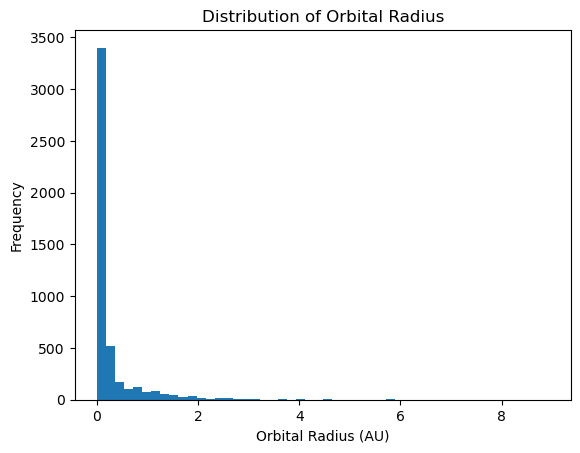

In [17]:
plt.hist(data['orbital_radius_log'], bins=50)
plt.xlabel('Orbital Radius (AU)')
plt.ylabel('Frequency')
plt.title('Distribution of Orbital Radius')
plt.show()

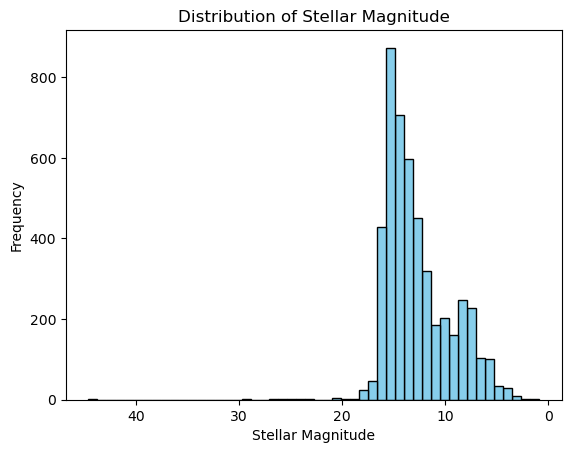

In [18]:
plt.hist(data['stellar_magnitude'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Stellar Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Stellar Magnitude')
plt.gca().invert_xaxis()  # Magnitude scale is inverse, brighter stars have lower magnitude
plt.show()



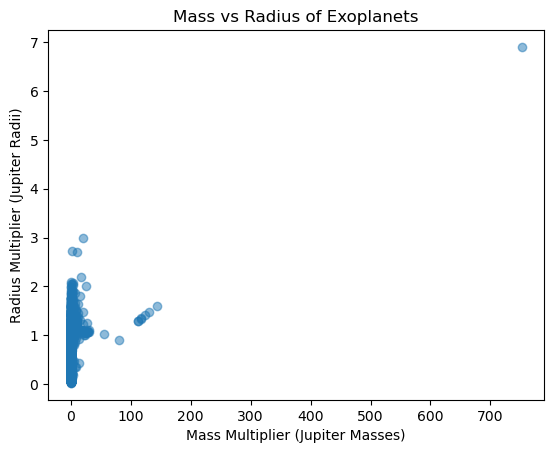

In [19]:
plt.scatter(data['mass_multiplier'], data['radius_multiplier'], alpha=0.5)
plt.xlabel('Mass Multiplier (Jupiter Masses)')
plt.ylabel('Radius Multiplier (Jupiter Radii)')
plt.title('Mass vs Radius of Exoplanets')
plt.show()


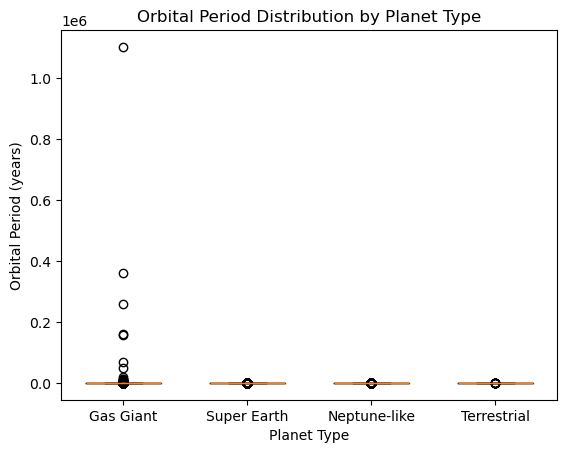

In [20]:
# Get the unique encoded planet types
encoded_planet_types = data['planet_type'].unique()
# Get the original planet type names using inverse_transform from the correct encoder
planet_type_names = label_encoders['planet_type'].inverse_transform(encoded_planet_types)

# Plotting
for encoded_planet_type in encoded_planet_types:
    subset = data[data['planet_type'] == encoded_planet_type]
    plt.boxplot(subset['orbital_period'], positions=[encoded_planet_type], widths=0.6)

plt.xlabel('Planet Type')
plt.ylabel('Orbital Period (years)')
plt.title('Orbital Period Distribution by Planet Type')
# Set the x-axis ticks to the unique planet types and label them with the original names
plt.xticks(ticks=np.arange(len(encoded_planet_types)), labels=planet_type_names)
plt.show()



## K-nearest neighbours

### import libraries

In [21]:
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### Defining functions that will be used for K-nearest neighbours

In [22]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

class kNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [30]:
# Convert DataFrame to numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_train_np = Y_train.to_numpy()

# Calculate the square root of the number of samples in the training set
k = int(np.sqrt(len(X_train_np)))

# If k is even, add or subtract 1 because k should be odd to avoid ties
if k % 2 == 0:
    k += 1

# Use numpy arrays for kNN
clf = kNN(k=k)
clf.fit(X_train_np, Y_train_np) 
predictions = clf.predict(X_test_np)



In [31]:
# To evaluate the model
from sklearn.metrics import accuracy_score
print("kNN model accuracy:", accuracy_score(Y_test.to_numpy(), predictions))

kNN model accuracy: 0.5047219307450157


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
predictions = clf.predict(X_test_np)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test.to_numpy(), predictions)

# Generate a classification report
class_report = classification_report(Y_test.to_numpy(), predictions, target_names=label_encoders['planet_type'].classes_)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[186  60  69   0]
 [ 43 189 100   0]
 [ 41 135 106   0]
 [  4  10  10   0]]

Classification Report:
               precision    recall  f1-score   support

   Gas Giant       0.68      0.59      0.63       315
Neptune-like       0.48      0.57      0.52       332
 Super Earth       0.37      0.38      0.37       282
 Terrestrial       0.00      0.00      0.00        24

    accuracy                           0.50       953
   macro avg       0.38      0.38      0.38       953
weighted avg       0.50      0.50      0.50       953



/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
